<a href="https://colab.research.google.com/github/amir-asari/SEBB4083-AI--202220232/blob/main/SEBB4083_ProstateCancerCase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

inspired from https://github.com/francisco-simoes/prostate-cancer_multilinear-regression/blob/master/ProstateCancer.ipynb

Prostate data info

Predictors (columns 1--8)

lcavol
lweight
age
lbph
svi
lcp
gleason
pgg45

outcome (column 9)

lpsa

train/test indicator (column 10)

This last column indicates which 67 observations were used as the 
"training set" and which 30 as the test set, as described on page 48
in the book.

There was an error in these data in the first edition of this
book. Subject 32 had a value of 6.1 for lweight, which translates to a
449 gm prostate! The correct value is 44.9 gm. We are grateful to
Prof. Stephen W. Link for alerting us to this error.

The features must first be scaled to have mean zero and  variance 96 (=n)
before the analyses in Tables 3.1 and beyond.  That is, if x is the  96 by 8 matrix
of features, we compute xp <- scale(x,TRUE,TRUE)

In [7]:
import pandas as pd
# url = 'https://hastie.su.domains/ElemStatLearn/datasets/prostate.data'
# url='http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data'
url='prostate.data.txt'
df_original_data = pd.read_table(url)

In [8]:
df_original_data.head()


,Unnamed: 0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [9]:
df_original_data.count()

Unnamed: 0    97
lcavol        97
lweight       97
age           97
lbph          97
svi           97
lcp           97
gleason       97
pgg45         97
lpsa          97
train         97
dtype: int64

he unnamed column is useless, so we'll delete it. We will also delete the 'train' column, since it just lets us know what rows were used as part of the training set in the original analysis in [Hastie].

In [10]:
df = df_original_data.copy(deep=True)
df = df.drop(columns=['Unnamed: 0','train'])
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


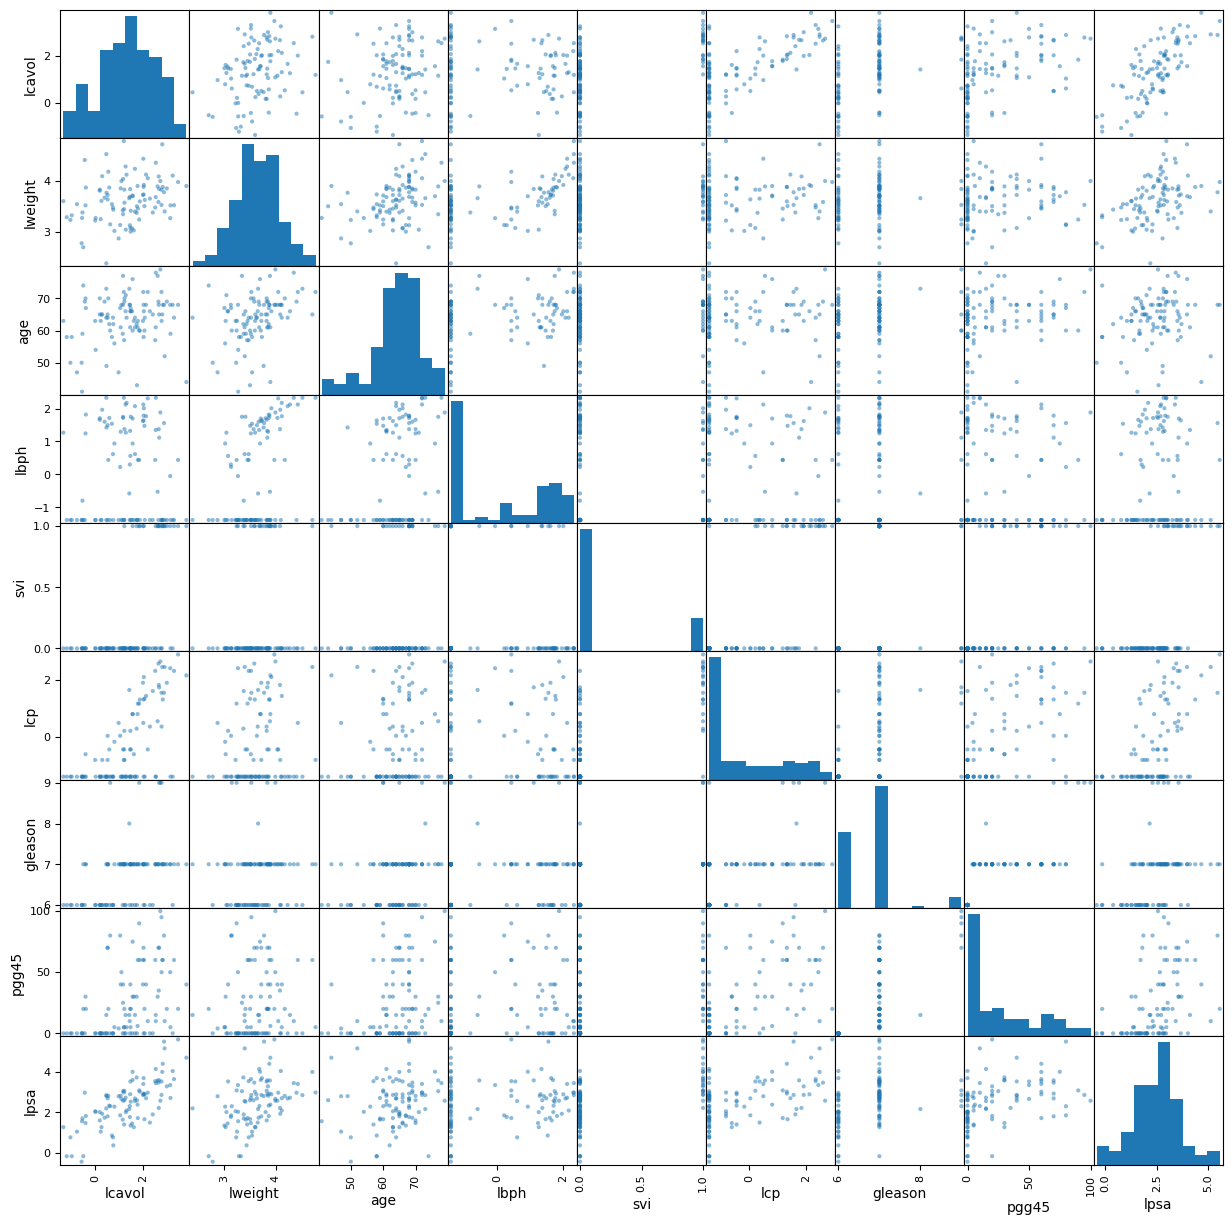

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.savefig('scatter_prostate.png')
plt.show()

Notice that there are two categorical/discrete predictors/features, namely svi and gleason.
Also, it is immediately clear that there is a strong linear relationship between the response (independent variable) lpsa and the predictors lcavol, lweight, svi and lcp.
The predictors lcavol and lcp seem to be strongly related as well, so maybe we will need only one of them. We will explore this later.

In [12]:
corr = df.corr()
corr.style.background_gradient()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000000,0.280521,0.225000,0.027350,0.538845,0.675310,0.432417,0.433652,0.734460
lweight,0.280521,1.000000,0.347969,0.442264,0.155385,0.164537,0.056882,0.107354,0.433319
age,0.225000,0.347969,1.000000,0.350186,0.117658,0.127668,0.268892,0.276112,0.169593
lbph,0.027350,0.442264,0.350186,1.000000,-0.085843,-0.006999,0.077820,0.078460,0.179809
svi,0.538845,0.155385,0.117658,-0.085843,1.000000,0.673111,0.320412,0.457648,0.566218
lcp,0.675310,0.164537,0.127668,-0.006999,0.673111,1.000000,0.514830,0.631528,0.548813
gleason,0.432417,0.056882,0.268892,0.077820,0.320412,0.514830,1.000000,0.751905,0.368987
pgg45,0.433652,0.107354,0.276112,0.078460,0.457648,0.631528,0.751905,1.000000,0.422316
lpsa,0.734460,0.433319,0.169593,0.179809,0.566218,0.548813,0.368987,0.422316,1.000000




Looking at the lpsa column or row, one sees that the correlations agree what our expectations, except perhaps in the case of pgg45, which is more strongly correlated with the response lpsa than expected. This gives us an idea of what to expect in terms of the dependence of lpsa on the predictors, but we'll conduct the analysis in a controlled manner using Z-scores later in this project.


##Standardization of the variables

We now standardize the predictors, so that we will end up with and for every variable (up to computational errors).

In [13]:
#Means and standard deviations before standardization.
df.describe().loc[['mean', 'std']]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329


In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#If we simply applied the scaler to our dataframe df we would lose the column labels.
#So instead we loop over the columns:
iterator = pd.DataFrame(df.iloc[:,:-1]).items() #Will not change the response, only the predictors.
for column,_ in iterator:
    column_data = pd.DataFrame(df[column]) #Create dataframe with a single column.
    new_column_array = scaler.fit_transform(column_data) #The scaler transforms the column.
    df[column] = pd.DataFrame(new_column_array) #Update column.
#Means and standard deviations after standardization.
df.describe().loc[['mean', 'std']]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,4.578239e-17,6.844468e-16,4.131861e-16,-2.432190e-17,-3.662591e-17,3.662591e-17,-2.174664e-17,5.636957e-17,2.478387
std,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.154329



##A first model (Using all features)

Let's build a first linear model with all the predictors.

We will split the data using the mask from the original table.


In [15]:
mask_origin = df_original_data['train']
mask_origin.tail()

92    T
93    T
94    F
95    T
96    F
Name: train, dtype: object

In [16]:
mask = mask_origin == 'T'
mask.tail()

92     True
93     True
94    False
95     True
96    False
Name: train, dtype: bool

In [17]:
df[mask].tail()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
90,1.617422,1.109520,0.558151,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957,4.029806
91,1.008835,0.114086,-0.386947,0.864484,1.902379,-0.867655,0.344407,-0.334356,4.129551
92,1.262444,0.580608,0.558151,-1.030029,1.902379,1.079149,0.344407,1.269449,4.385147
93,2.107397,0.628738,-2.682185,-1.030029,1.902379,1.688267,0.344407,0.556647,4.684443
95,1.307045,0.340141,0.558151,1.010033,1.902379,1.249088,0.344407,1.982251,5.477509


In [18]:
train_df_from_source = df[mask]
test_df_from_source = df[~mask]

One can at last build the model (using least-squares estimation). The LinearRegression class from sklearn does just that:

In [19]:
from sklearn.linear_model import LinearRegression
print(LinearRegression.__doc__[1:45])

    Ordinary least squares Linear Regression


In [33]:
import numpy as np
X_train = train_df_from_source.iloc[:,0:-1] #The last column contains the response lpsa.
y_train = train_df_from_source.iloc[:,-1]
model = LinearRegression().fit(X = X_train, y = y_train)
print(' intercept: {} \n coeficients: '.format(model.intercept_))
coefs_df = pd.DataFrame(data=np.array([model.coef_]), columns=X_train.columns, index=['coeficients'])
coefs_df

 intercept: 2.4649329221237446 
 coeficients: 


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
coeficients,0.676016,0.261694,-0.140734,0.209061,0.303623,-0.287002,-0.021195,0.265576


In [34]:
# Predict target variable on test set
X_test = test_df_from_source.iloc[:,0:-1] #The last column contains the response lpsa.
y_test = test_df_from_source.iloc[:,-1]
y_pred = model.predict(X_test)

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Evaluate model performance on test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('R-squared:', r2)

MSE: 0.5212740055076
R-squared: 0.503379850238181


##A second model (using the best feature-lcavol)

Let's build a first linear model with all the predictors.

We will split the data using the mask from the original table.

In [28]:
X_train = train_df_from_source.iloc[:,0:1] #The last column contains the response lpsa.
y_train = train_df_from_source.iloc[:,-1]
model = LinearRegression().fit(X = X_train, y = y_train)
print(' intercept: {} \n coeficients: '.format(model.intercept_))
coefs_df = pd.DataFrame(data=np.array([model.coef_]), columns=X_train.columns, index=['coeficients'])
coefs_df



 intercept: 2.478369115001615 
 coeficients: 


,lcavol
coeficients,0.835589


In [31]:
# Predict target variable on test set
X_test = test_df_from_source.iloc[:,0:1] #The last column contains the response lpsa.
y_test = test_df_from_source.iloc[:,-1]
y_pred = model.predict(X_test)

In [32]:
# Evaluate model performance on test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('R-squared:', r2)

MSE: 0.4797387195768276
R-squared: 0.5429507087528963
